<a href="https://colab.research.google.com/github/CBravoR/AdvancedAnalyticsLabs/blob/master/notebooks/python/Lab_6_Logistic_Regression_and_Scorecards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression and Scorecards

In this lab we will finally start running models! For this we will use the excellent [```scikit-learn```](https://scikit-learn.org/stable/) package, which implements many, many data science methods. This is the go-to tool for any structured data analysis package.

First, we will import the data from last week. We will download them from my Google Drive.

In [1]:
# Import the csv files from last week.
!gdown 'https://drive.google.com/uc?id=1LWRFLpJtTopAlRqTuUd9XZvGB6CoHa2z'
!gdown 'https://drive.google.com/uc?id=1IvY78EGu-eizec_9agJUsQWDLT-wmSHF'
!gdown 'https://drive.google.com/uc?id=1aDraDSR2OQbIMjIY07s-rD5cel2x_iS-'

Downloading...
From: https://drive.google.com/uc?id=1LWRFLpJtTopAlRqTuUd9XZvGB6CoHa2z
To: /content/test_woe.csv
100% 62.9k/62.9k [00:00<00:00, 47.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IvY78EGu-eizec_9agJUsQWDLT-wmSHF
To: /content/train_woe.csv
100% 147k/147k [00:00<00:00, 23.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aDraDSR2OQbIMjIY07s-rD5cel2x_iS-
To: /content/BankloanCleanNewVars.pkl
100% 146k/146k [00:00<00:00, 22.7MB/s]


In [2]:
!ls

BankloanCleanNewVars.pkl  sample_data  test_woe.csv  train_woe.csv


Now we install the scorecardpy package and clean our data.

In [3]:
!pip install git+https://github.com/CBravoR/scorecardpy

  Cloning https://github.com/CBravoR/scorecardpy to /tmp/pip-req-build-km0ux_0y
  Running command git clone --filter=blob:none --quiet https://github.com/CBravoR/scorecardpy /tmp/pip-req-build-km0ux_0y
  Resolved https://github.com/CBravoR/scorecardpy to commit 0d783ffa8eed583efaffc7c50267fefd610700ff
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.4-py3-none-any.whl size=59543 sha256=004a9e74b17aa62a18176b7609a4b19479425299c1a027a5ef9c9924cd2cfd25
  Stored in directory: /tmp/pip-ephem-wheel-cache-nd1wq1c8/wheels/60/8b/2e/5fca55c312c69f7f1b0a77ccd9794507c5e4cc2a510e2d47c9
Successfully built scorecardpy


In [4]:
# Package loading
import pandas as pd
import numpy as np
import scorecardpy as sc
from string import ascii_letters

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# Import the files as Pandas datasets
bankloan_train_WoE = pd.read_csv('train_woe.csv')
bankloan_test_WoE = pd.read_csv('test_woe.csv')
bankloan_data = pd.read_pickle('BankloanCleanNewVars.pkl')

# Eliminate unused variables
bankloan_data.drop(columns=['Education'], inplace = True)
bankloan_train_WoE.drop(columns=['Education_woe'], inplace = True)
bankloan_test_WoE.drop(columns=['Education_woe'], inplace = True)


# Same train-test split as before (because of seed!)
bankloan_train_noWoE, bankloan_test_noWoE = sc.split_df(bankloan_data.iloc[:, 1:],
                                                        y = 'Default',
                                                        ratio = 0.7,
                                                        seed = 20190227).values()

# Give breaks for WoE
breaks_adj = {'Address': [1.0,2.0,8.0,17.0],
              'Age': [30.0,45.0,50.0],
              'Creddebt': [1.0, 6.0],
              'Employ': [4.0,14.0,22.0],
              'Income': [30.0,40.0,80.0,140.0],
              'Leverage': [8.0,16.0,22.0],
              'MonthlyLoad': [0.1,0.2,0.30000000000000004,0.7000000000000001],
              'OthDebt': [1.0,2.0,3.0],
              'OthDebtRatio': [0.01,0.05,0.07,0.09,0.14]
              }

# Apply breaks.
bins_adj = sc.woebin(bankloan_train_noWoE, y="Default",
                     breaks_list=breaks_adj)


[INFO] creating woe binning ...


/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/usr/local/lib/python3.11/dist-packages/scorecardpy/condition_fun.py:25: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()


## Generating a logistic regression object

To train a logistic regression, we first need to create an object that stores how we want the model to be trained. In general, all of scikit-learn models work this way:

- We create the model we want to train, with all required parameters. This model is **not trained yet**, it just keeps the logic we will use.

- We apply the ```fit``` function to the object we just created. This takes as input the training set and the targets (if the model is supervised), and will update our model with trained parameters.

- We then used our trained model to apply it to a test set, and calculate outputs.

Logistic regression is included in the [```linear_model subpackage```](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) and it comes pre-packaged with all regularization algorithms: the LASSO penalization, the Ridge penalization and the ElasticNet method (refer to the lectures for the explanation of these, or read this [excellent tutorial](https://codingstartups.com/practical-machine-learning-ridge-regression-vs-lasso/)).

In a nutshell, LASSO and Ridge are going to penalize including variables by adding either a linear (LASSO) or quadratic (Ridge) term to the minimization algorithm, or a combination of the two if using Elastic Net.

These methods have hypermparameters that need to be optimized. For this we will use a cross-validation procedure (again, refer to the lectures). Luckily for us, scikit-learn already comes with an object that will allow cross-validated optimization of the penalization parameter. The function to call is[```LogisticRegressionCV```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

Let's start by creating this object.




In [36]:
from sklearn.linear_model import LogisticRegressionCV

bankloan_logreg = LogisticRegressionCV(penalty='elasticnet', # Type of penalization l1 = lasso, l2 = ridge, elasticnet
                                     Cs = 10,        # How many parameters to try. Can also be a vector with parameters to try.
                                     tol=0.000001, # Tolerance for parameters
                                     cv = 3,     # How many CV folds to try. 3 or 5 should be enough.
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=20190301, # Random seed
                                     max_iter=100, # Maximum iterations
                                     verbose=2, # Show process. 1 is yes.
                                     solver = 'saga', # How to optimize.
                                     n_jobs = 2,      # Processes to use. Set to number of physical cores.
                                     refit = True,     # If to retrain with the best parameter and all data after finishing.
                                     l1_ratios = np.arange(0, 1.01, 0.1), # The LASSO / Ridge ratios.
                                    )

Let's dig deeper into what is needed.

**Penalty**

'l1' penalty refers to LASSO regression (great at selecting variables), 'l2' to Ridge regression (not very good at selecting variables), and 'elasticnet'. My advice: As long as you have more samples than variables, start with LASSO, if it doesn't work or you are not happy with the results, move to elasticnet.

**Penalty constants to try (```Cs```)**

This refers to how many LASSO or Ridge parameters to try. These parameters measure the weight of the error in prediction versus the regularization (penalty) error. When optimizing the parameters, a penalization constant will try to optimise the following:

$$
Error = Error_{prediction} + \frac{1}{C} \times Error_{penalty}
$$

So the $C$ constant will balance both objectives. By giving a Cs larger than 1, it will try as many parameters as given.

**Class weighting**

Most interesting problems are unbalanced. This means the interesting class (Default in our case) has less cases than the opposite class. Models optimise the sum over **all** cases, so if we minimize the error, which class do you think will be better classified?

This means we need to balance the classes to make them equal. Luckily for us, Scikit-Learn includes automatic weighting that assigns the same error to both classes. The error becomes the following:

$$
Error = Weight_1 \times Error_{predictionClass1} + Weight_2 \times Error_{predictionClass2} + \frac{1}{C} \times Error_{penalty}
$$

The weights are selected so the theoretical maximum error in both classes is the same (see the help for the exact equation).

**Random State**

The random seed. Remember to use your student ID.

**Iterations**

The solution comes from an iterative model, thus we specify a maximum number of iterations. Remember to check for convergence after it has been solved!

**Solver**

Data science functions are complex ones, with thousands, millions, or even billions of parameters. Thus we need to use the best possible solver for our problems. Several are implemented in scikit-learn. The help states that:


- For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.
- For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.
- ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ handle L1 penalty.

We will use 'saga', a very efficient solver. You can read all about it [here](https://www.di.ens.fr/~fbach/Defazio_NIPS2014.pdf).

**refit**

If your data is sufficiently small to fit in memory, you will be able to use all of the training data for the cross-validation process. If so, then with ```refit=True``` you will retrain the model after the parameter search, using the optimal parameter found.

However, in large datasets this might not be possible. In this case:

1. Obtain a **validation sample** from the original training data. Usually 20% of data is used, but it depends on memory and time constraints.

2. Run the Cross-validation process over this validation data and find the optimal parameter. Let's call it $C^*$.

3. Train a logistic regression with all training data, but with a fixed parameter $C^*$. For this you need to use the function [```LogisticRegression```](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression) in scikit-learn and give the parameter ```C=YOUR_OPTIMAL_C```. The rest of the parameters are similar to ```LogisticRegressionCV```.

The ```LogisticRegression``` object has another interesting interesting parameter for big data models. ```warm_start```.

**Warm start**

Scikit-learn allows for multiple adjustments to the training. For example, you can try first with a little bit of data just to check if everything is working, and then, if you set ```warm_start = True``` before, it will retrain starting from the original parameters. Allows for dynamic updating as well.  ```warm_start = False``` means whenever we give it new data, it will start from scratch, forgetting what it previously learned.

**l1_ratios**

These are the balance parameters between LASSO and Ridge for the ElasticNet optimization, with 0 <= l1_ratio <= 1. A value of 0 is equivalent to using penalty='l2', while 1 is equivalent to using penalty='l1'.

## Training!

Now we are ready to train. We simply apply the method ```fit``` to our data, giving it the training set and the target variable as inputs.

In [37]:
bankloan_train_WoE.columns

Index(['Default', 'Employ_woe', 'Leverage_woe', 'MonthlyLoad_woe', 'Age_woe',
       'Creddebt_woe', 'Income_woe'],
      dtype='object')

In [39]:
bankloan_logreg.fit(X = bankloan_train_WoE.iloc[:, 1:], # All rows and from the second var to end
                    y = bankloan_train_WoE['Default'] # The target
                   )

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 1 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling

[Parallel(n_jobs=2)]: Done  33 out of  33 | elapsed:    2.1s finished


LogisticRegressionCV(class_weight='balanced', cv=3,
                     l1_ratios=array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                     n_jobs=2, penalty='elasticnet', random_state=20190301,
                     solver='saga', tol=1e-06, verbose=2)

Let's read the output:

```convergence after 25 epochs took 0 seconds```

The method was able to find a solution at the given tolerance, and it took 16 iterations and almost no time. **If the method says it did not converge then you need to increase iterations, change C or both!**.

The rest of the output refers to what it did, it is not relevant at this stage.

Done! We have a logistic regression! Let's check the parameters, sorted into a nice table.


In [40]:
coef_df = pd.concat([pd.DataFrame({'column': bankloan_train_WoE.columns[1:]}),
                    pd.DataFrame(np.transpose(bankloan_logreg.coef_))],
                    axis = 1
                   )

coef_df

,column,0
0,Employ_woe,0.828402
1,Leverage_woe,0.628779
2,MonthlyLoad_woe,0.289876
3,Age_woe,0.527221
4,Creddebt_woe,0.837396
5,Income_woe,-0.161489


We can see the parameter for each variable now. This does not include the constant. We can get it with

In [41]:
bankloan_logreg.intercept_

array([0.00549645])

We can see all variables are being used, and the intercept is really close to 0. This is expected in a balanced logistic regression that uses WoE transform and is a way to check everything is working as intended.

We can see that all coefficients are correctly determined, even in the presence of correlations. This happens because the **ElasticNet penalty deals with correlations gracefully**. This is NOT the case if we had a LASSO regression. Try it yourself and see. In that case, you would need to manually eliminate the variables so everything works correctly.

We can also check the optimal hyperparameters found.

In [42]:
print(bankloan_logreg.l1_ratio_)
print(bankloan_logreg.C_)

[0.1]
[0.04641589]


## Applying to the test set

We can now apply our results to the test set, and check our results. Most models in scikit-learn have the ```predict``` method which applies the model to new data, this gives the 0-1 prediction. Alternatively (and more usefully) we can use the ```predict_proba``` method that gives the probability.

In [44]:
pred_class_test = bankloan_logreg.predict(bankloan_test_WoE.iloc[:, 1:])
probs_test = bankloan_logreg.predict_proba(bankloan_test_WoE.iloc[:, 1:])
print(probs_test[0:5], pred_class_test[0:5])

[[0.86270812 0.13729188]
 [0.49506731 0.50493269]
 [0.36625672 0.63374328]
 [0.5483935  0.4516065 ]
 [0.88330038 0.11669962]] [0 1 1 0 0]


Scikit-learn will give, by default, one probability per class.  The second column is the one that applies for class Default = 1.

We will get the confusion matrix to check our accuracy. These are included in the subpackage ```sklearn.metrics``` and we will plot it using seaborn.

In [45]:
from sklearn.metrics import confusion_matrix

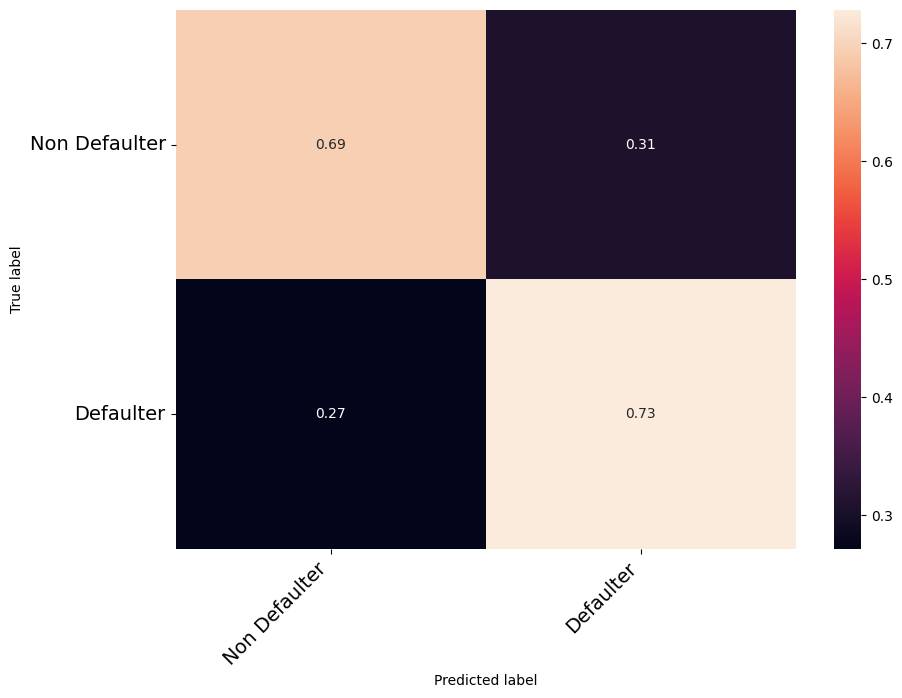

In [46]:

# Calculate confusion matrix
confusion_matrix_cs = confusion_matrix(y_true = bankloan_test_WoE['Default'],
                                        y_pred = pred_class_test)


# Turn matrix to percentages
confusion_matrix_cs = confusion_matrix_cs.astype('float') / confusion_matrix_cs.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(
        confusion_matrix_cs, index=['Non Defaulter', 'Defaulter'],
        columns=['Non Defaulter', 'Defaulter'],
)

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0,
                             ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,
                             ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

Pretty good model! Let's bootstrap the AUC to get the confidence interval over the test set.

In [47]:
from sklearn.metrics import roc_auc_score

# Calculate bootstrap
test_preds = pd.DataFrame({'classes': bankloan_test_WoE['Default'],
                           'probs': probs_test[:,1]})
auc_boot = []

# Use 10,000 samples for IRL applications
for i in np.arange(1000):
  sample = test_preds.sample(n=447, replace=True)
  auc_boot.append(roc_auc_score(sample['classes'], sample['probs']))


In [48]:
# Calculate differences
auc_total = roc_auc_score(test_preds['classes'], test_preds['probs'])
auc_boot -= auc_total

In [49]:
# Calculate percentile
lower = np.percentile(auc_boot, 2.5)
upper = np.percentile(auc_boot, 97.5)

In [50]:
print(f'The confidence interval of the AUC is [{auc_total - upper:.3f}, {auc_total - lower:.3f}]')

The confidence interval of the AUC is [0.747, 0.829]


Let's create a scorecard now!

## Scorecards

The package ```scorecardpy``` has the function ```scorecard``` which receives a trained logistic regression model trained over WoE-transformed data, a trained scorecard **over the same variables** and a list of matched columns (that is, the order of columns in the scorecard). As optional arguments it receives a PDO, a base score, and decimal base odds (so instead of 50:1, it receives 0.02).

You should adjust these values so the score is in a range that's acceptable. Typically between 0 and 1000.

In [52]:
bankloan_sc = sc.scorecard(bins_adj,         # bins from the WoE
                           bankloan_logreg,  # Trained logistic regression
                           bankloan_train_WoE.columns[1:], # The column names in the trained LR
                           points0=750, # Base points
                           odds0=0.01, # Base odds bads:goods
                           pdo=50 # PDO
                           )


In [20]:
print(bankloan_sc)

{'basepoints':      variable  bin  points
0  basepoints  NaN   418.0, 'Employ':    variable          bin  points
22   Employ   [-inf,4.0)   -33.0
23   Employ   [4.0,14.0)    21.0
24   Employ  [14.0,22.0)    70.0
25   Employ   [22.0,inf)   156.0, 'Education':      variable            bin  points
35  Education            Bas     5.0
36  Education  Posg%,%SupInc     1.0
37  Education            Med    -0.0
38  Education         SupCom    -5.0, 'Leverage':     variable          bin  points
18  Leverage   [-inf,8.0)    35.0
19  Leverage   [8.0,16.0)    -9.0
20  Leverage  [16.0,22.0)   -44.0
21  Leverage   [22.0,inf)   -87.0, 'MonthlyLoad':        variable                                       bin  points
8   MonthlyLoad                                [-inf,0.1)    28.0
9   MonthlyLoad                                 [0.1,0.2)    15.0
10  MonthlyLoad                 [0.2,0.30000000000000004)     8.0
11  MonthlyLoad  [0.30000000000000004,0.7000000000000001)    -8.0
12  MonthlyLoad            

In [53]:
# Applying the credit score. Applies over the original data!
train_score = sc.scorecard_ply(bankloan_train_noWoE, bankloan_sc,
                               print_step=0)
test_score = sc.scorecard_ply(bankloan_test_noWoE, bankloan_sc,
                               print_step=0)

/usr/local/lib/python3.11/dist-packages/scorecardpy/scorecard.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)
/usr/local/lib/python3.11/dist-packages/scorecardpy/scorecard.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


In [54]:
train_score.describe()

,score
count,1035.000000
mean,434.326570
std,94.600011
min,185.000000
25%,370.000000
50%,431.000000
75%,483.000000
max,724.000000


And that's it! We have a fully functional credit scorecard. In later labs we will contrast this with two more models: a Random Forest and an XGBoost model.